### Ship sailing strategies with various combinations of payloads and velocities for passing a bottleneck waterway section

### Steps before sailing: 
- Giving a sailing route, in which there is an section with limited water depth (h_min)
- Listing a group of possible actual draughts depending on the limited water depth and minimum operating draughts
- Using the T2v function to find out the corresponding velocities the ship can sail with to safely pass the bottlenek without grounding
- Displaying the possible actual draughts with its maximum sailing velocities and suggesting several sailing strategies.

### Steps while sailing: 
- c

### Test the reality of sailing with v_computed
We test it by comparing the total required power (P_tot) of the ship while sailing at v_computed with its installed power (P_installed). If P_tot <= P_installed, the v_computed is realistic.

So the steps to do:
- set the above results [Strategies: 'T_strategy','v_computed'] as input data for a vessel sailing and consuming energy simulation
- run the simulation to get results: 'P_tot', 'P_installed', 'total fuel use', 'total emissions_CO2', 'total emissions_PM10', 'total emissions_NOx', 'duration', 'payload'. (Note that you need the "T2payload" function based on "Van Dorsser's method" to get the corresponding 'payload'for each 'T_strategy'.) 
- put the results into dataframe for later easy selecting, processing and plotting
- select the Strategies of which P_tot <= P_installed 
- analysis the selected Strategies 
- visualize some typical selected Strategies via a series Bar Chart. In each bar chart, y_axis is amount, x_axis is evaluation items.
- visualize some typical selected Strategies together with ambient waterway sections of different water depths.(Note that the input [Vs, P_tot_given] are different for bottle neck section and ambient sections)

### 0. Load packages

In [1]:
import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# OpenTNSim
import opentnsim
import opentnsim.strategy
# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

### 1. Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.8983,0], 
    [1.7966,0], 
    [2.6949,0]] 

# for each edge (between above coordinates) specify the depth (m)
depths = [6, 2.5, 6]

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": depths[index]})

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

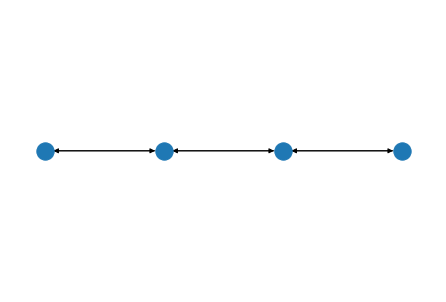

In [4]:
# show graph
nx.draw(FG, positions)
plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 0', 'Node 1') is 6
General depth for edge ('Node 1', 'Node 0') is 6
General depth for edge ('Node 1', 'Node 2') is 2.5
General depth for edge ('Node 2', 'Node 1') is 2.5
General depth for edge ('Node 2', 'Node 3') is 6
General depth for edge ('Node 3', 'Node 2') is 6


In [6]:
FG.get_edge_data('Node 1', 'Node 2')["Info"]["GeneralDepth"]

2.5

### 2. Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption.  

In [33]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [34]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type": 'Dortmund-Eems (L <= 74 m)', # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }          

### 3. Find path and h_min
We are going to create a simulation in which a vessel moves from *Node 0* to *Node 3*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [35]:
path = nx.dijkstra_path(FG, nodes[0].name, nodes[3].name)

In [36]:
h_min = np.inf
for edge in FG.edges:
    h_min=min([h_min, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]])
print('minimum waterdepth along path is {} m'.format(h_min))

minimum waterdepth along path is 2.5 m


### 4. Define max_sinkage_at_v_strategy function to know the maximum sinkage for a possible velocity 

In [46]:
def get_v(vessel, width, depth, margin, bounds):
    ''' for a waterway section with a given width and depth, compute the velocity that can be 
    reached given a vessel's T and a safety margin.'''
    

    def seek_v_given_z(v, vessel, width, depth, margin):
        # calculate sinkage

        z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (width * depth)) ** 0.81) * ((v*1.94) ** 2.08) / 20

        # calculate available underkeel clearance (vessel in rest)
        z_given = depth - vessel._T

        # compute difference between the sinkage and the space available for sinkage (including safety margin)
        diff = z_given - z_computed - margin 

        return diff ** 2

    # goalseek to minimize
    fun = functools.partial(seek_v_given_z, vessel=vessel, width=width, depth=depth, margin=margin)
    fit = scipy.optimize.minimize_scalar(fun, bounds=bounds, method='bounded')

    # check if we found a minimum
    if not fit.success:
        raise ValueError(fit)

    # the value of fit.x within the bound (0,20) is the velocity we find where the diff**2 reach a minimum (zero).
    v =  fit.x
    
    # calculate the key values again for the resulting speed
    z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (width * depth)) ** 0.81) * ((v*1.94) ** 2.08) / 20
    depth_squat = depth - z_computed 

    return v, depth, depth_squat, z_computed, margin   

In [94]:
def get_upperbound_for_power2v(vessel, width, depth, margin=0, bounds=(0,20)):
    ''' for a waterway section with a given width and depth, compute a maximum installed-
    power-allowed velocity, considering squat. This velocity can be used as upperbound in the 
    power2v function in energy.py. The "upperbound" is the maximum value in velocity searching 
    range.'''

    # estimate the grounding velocity 
    grounding_v, depth, depth_squat, z_computed, margin = get_v(vessel, width, depth, margin=0, bounds=bounds)
    
    # find max power velocity
    velocity = np.linspace(0.01, grounding_v, 1000) 
    task = list(itertools.product(velocity[0:-1]))

    # prepare a list of dictionaries for pandas
    rows = []
    for item in task:
        row = {"velocity": item[0]}
        rows.append(row)

    # convert simulations to dataframe, so that we can apply a function and monitor progress
    task_df = pd.DataFrame(rows)
    
    # creat a results empty list to collect the below results
    results = []   
    for i, row in tqdm.tqdm(task_df.iterrows()):
        # calculate squat and the waterdepth after squat
        z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (width * depth)) ** 0.81) * ((row['velocity']*1.94) ** 2.08) / 20
    
        # calculate squatted waterdepth
        h_0 = depth  - z_computed
        
        # for the squatted water depth calculate resistance and power
        vessel.calculate_total_resistance(v=row['velocity'], h_0=h_0)
        vessel.calculate_total_power_required(v=row['velocity'])
        
        # prepare a row
        result = {}
        result.update(row)
        result['Powerallowed_v'] = row['velocity']
        result['P_tot'] = vessel.P_tot
        result['P_installed'] = vessel.P_installed
        result['h_0'] = depth
        result['z_computed'] = z_computed
        result['h_squat'] = h_0
        
        # update resulst dict
        results.append(result)
    
    results_df = pd.DataFrame(results)

    # return only dataframe up to and including the first time that P_tot == P_installed
    selected = results_df[0:(results_df.P_installed>=results_df.P_tot).idxmin()]

    upperbound = selected.Powerallowed_v.max()

    return upperbound, selected, results_df

### 5. Create a worklist of strategies

In [102]:
# provide max and min draught
max_draught = 2.30
min_operational_draught = 1.50
stepsize = -0.05

# create lists of strategy values
T_strategy = np.arange(max_draught, min_operational_draught+stepsize, stepsize).round(2).tolist()
h_min = [2.5]
safety_margin = [0.2]
width = [150]

In [103]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T_strategy,h_min,safety_margin,width
12,1.70,2.5,0.2,150
13,1.65,2.5,0.2,150
14,1.60,2.5,0.2,150
15,1.55,2.5,0.2,150
16,1.50,2.5,0.2,150


### 6. Run the strategies

In [104]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    display(row)

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    #     results_df = get_upperbound_for_power2v(vessel, width=width, depth=row['h_min'], margin=0.2)
    # get v_T2v in the bottleneck section
#     v_T2v  = opentnsim.strategy.T2v(vessel, h_min = row['h_min'])
    
#     # get v_P2v in the bottleneck section
#     upperbound = opentnsim.energy.get_upperbound_for_power2v(vessel, width=150, depth=row['h_min'])

#     v_P2v = opentnsim.strategy.P2v(vessel, h_min = row['h_min'], upperbound = upperbound)
#     # get final maximum velocity in the bottleneck section
#     v_max_final = min(v_T2v, v_P2v)
    
#     print(v_max_final)

#     v_T2v, v_P2v, v_max_final = opentnsim.strategy.get_v_max_for_bottleneck(FG, path_bottleneck, vessel, T_strategy)
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
#     v_strategy, max_sinkage = max_sinkage_at_v_strategy (vessel,T_strategy, v_max_final)
# #     remained_distance_to_margin = row['h_min'] - row['T_strategy'] - max_sinkage - safety_margin

# #     print('upperbound velocity {:.2f} m/s'.format(bottleneck_upperbound))
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound    
    Strategy['v_strategy (m/s)'] = v
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
# #     Strategy['remained_distance_to_margin (cm)'] = remained_distance_to_margin * 100
# #     Strategy['v_max_(sinkage_allowed) (m/s)'] = v_T2v
#     Strategy['v_max_(power_allowed) (m/s)'] = bottleneck_upperbound    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

0it [00:00, ?it/s]

T_strategy         2.3
h_min              2.5
safety_margin      0.2
width            150.0
Name: 0, dtype: float64


0it [00:00, ?it/s]
309it [00:00, 3059.54it/s]
615it [00:00, 2638.98it/s]
999it [00:00, 2388.44it/s]
1it [00:00,  2.28it/s]

T_strategy         2.25
h_min              2.50
safety_margin      0.20
width            150.00
Name: 1, dtype: float64


0it [00:00, ?it/s]
206it [00:00, 2044.41it/s]
411it [00:00, 2019.18it/s]
689it [00:00, 2362.31it/s]
999it [00:00, 2405.61it/s]
2it [00:00,  2.28it/s]

T_strategy         2.2
h_min              2.5
safety_margin      0.2
width            150.0
Name: 2, dtype: float64


0it [00:00, ?it/s]
289it [00:00, 2866.39it/s]
576it [00:00, 2792.24it/s]
999it [00:00, 2431.07it/s]
3it [00:01,  2.29it/s]

T_strategy         2.15
h_min              2.50
safety_margin      0.20
width            150.00
Name: 3, dtype: float64


0it [00:00, ?it/s]
260it [00:00, 2595.33it/s]
520it [00:00, 2532.35it/s]
999it [00:00, 2532.91it/s]
4it [00:01,  2.30it/s]

T_strategy         2.1
h_min              2.5
safety_margin      0.2
width            150.0
Name: 4, dtype: float64


0it [00:00, ?it/s]
284it [00:00, 2839.95it/s]
568it [00:00, 2822.33it/s]
999it [00:00, 2642.16it/s]
5it [00:02,  2.37it/s]

T_strategy         2.05
h_min              2.50
safety_margin      0.20
width            150.00
Name: 5, dtype: float64


0it [00:00, ?it/s]
286it [00:00, 2838.34it/s]
570it [00:00, 2524.30it/s]
999it [00:00, 2635.67it/s]
6it [00:02,  2.42it/s]

T_strategy         2.0
h_min              2.5
safety_margin      0.2
width            150.0
Name: 6, dtype: float64


0it [00:00, ?it/s]
297it [00:00, 2960.03it/s]
594it [00:00, 2741.98it/s]
999it [00:00, 2737.45it/s]
7it [00:02,  2.48it/s]

T_strategy         1.95
h_min              2.50
safety_margin      0.20
width            150.00
Name: 7, dtype: float64


0it [00:00, ?it/s]
298it [00:00, 2967.86it/s]
595it [00:00, 2513.44it/s]
999it [00:00, 2555.34it/s]
8it [00:03,  2.46it/s]

T_strategy         1.9
h_min              2.5
safety_margin      0.2
width            150.0
Name: 8, dtype: float64


0it [00:00, ?it/s]
287it [00:00, 2862.69it/s]
574it [00:00, 2663.74it/s]
999it [00:00, 2641.45it/s]
9it [00:03,  2.47it/s]

T_strategy         1.85
h_min              2.50
safety_margin      0.20
width            150.00
Name: 9, dtype: float64


0it [00:00, ?it/s]
271it [00:00, 2707.00it/s]
542it [00:00, 2358.80it/s]
999it [00:00, 2530.58it/s]
10it [00:04,  2.45it/s]

T_strategy         1.8
h_min              2.5
safety_margin      0.2
width            150.0
Name: 10, dtype: float64


0it [00:00, ?it/s]
271it [00:00, 2703.85it/s]
557it [00:00, 2793.19it/s]
999it [00:00, 2584.01it/s]
11it [00:04,  2.45it/s]

T_strategy         1.75
h_min              2.50
safety_margin      0.20
width            150.00
Name: 11, dtype: float64


0it [00:00, ?it/s]
229it [00:00, 2281.20it/s]
458it [00:00, 2136.18it/s]
673it [00:00, 2053.76it/s]
999it [00:00, 2025.77it/s]
12it [00:05,  2.27it/s]

T_strategy         1.7
h_min              2.5
safety_margin      0.2
width            150.0
Name: 12, dtype: float64


0it [00:00, ?it/s]
228it [00:00, 2261.40it/s]
455it [00:00, 2048.96it/s]
662it [00:00, 1951.91it/s]
999it [00:00, 2014.67it/s]
13it [00:05,  2.14it/s]

T_strategy         1.65
h_min              2.50
safety_margin      0.20
width            150.00
Name: 13, dtype: float64


0it [00:00, ?it/s]
118it [00:00, 1175.56it/s]
258it [00:00, 1306.75it/s]
395it [00:00, 1335.37it/s]
603it [00:00, 1628.03it/s]
766it [00:00, 1572.20it/s]
999it [00:00, 1576.44it/s]
14it [00:06,  1.88it/s]

T_strategy         1.6
h_min              2.5
safety_margin      0.2
width            150.0
Name: 14, dtype: float64


0it [00:00, ?it/s]
132it [00:00, 1294.70it/s]
262it [00:00, 1269.40it/s]
413it [00:00, 1376.38it/s]
570it [00:00, 1451.08it/s]
731it [00:00, 1502.65it/s]
999it [00:00, 1389.80it/s]
15it [00:07,  1.67it/s]

T_strategy         1.55
h_min              2.50
safety_margin      0.20
width            150.00
Name: 15, dtype: float64


0it [00:00, ?it/s]
181it [00:00, 1809.82it/s]
362it [00:00, 1762.19it/s]
539it [00:00, 1654.25it/s]
706it [00:00, 1161.67it/s]
838it [00:00, 826.77it/s] 
999it [00:01, 830.39it/s]
16it [00:08,  1.26it/s]

T_strategy         1.5
h_min              2.5
safety_margin      0.2
width            150.0
Name: 16, dtype: float64


0it [00:00, ?it/s]
164it [00:00, 1635.51it/s]
355it [00:00, 1791.26it/s]
535it [00:00, 1534.02it/s]
693it [00:00, 957.31it/s] 
813it [00:00, 1014.04it/s]
999it [00:00, 1052.58it/s]
17it [00:09,  1.83it/s]


In [105]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df.head(35))

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,2.30,2.50,0.20,150.00,2.95,0.00,0.00,2.50,2.50,1342.00
1,2.25,2.50,0.20,150.00,3.29,1.58,0.05,2.45,2.45,1284.59
2,2.20,2.50,0.20,150.00,3.56,2.23,0.10,2.40,2.40,1227.25
3,2.15,2.50,0.20,150.00,3.72,2.73,0.15,2.35,2.35,1169.98
4,2.10,2.50,0.20,150.00,3.75,3.17,0.20,2.30,2.30,1112.77
5,2.05,2.50,0.20,150.00,3.76,3.56,0.25,2.25,2.25,1055.62
6,2.00,2.50,0.20,150.00,3.76,3.76,0.27,2.23,2.20,998.53
7,1.95,2.50,0.20,150.00,3.76,3.76,0.27,2.23,2.15,941.51
8,1.90,2.50,0.20,150.00,3.77,3.77,0.26,2.24,2.10,884.55
9,1.85,2.50,0.20,150.00,3.76,3.76,0.26,2.24,2.05,827.66


In [106]:
Strategies_df

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,2.30,2.5,0.2,150.0,2.954841,0.000006,2.325408e-13,2.500000,2.50,1341.996625
1,2.25,2.5,0.2,150.0,3.293707,1.584117,4.999993e-02,2.450000,2.45,1284.593609
2,2.20,2.5,0.2,150.0,3.555272,2.230048,1.000000e-01,2.400000,2.40,1227.254179
3,2.15,2.5,0.2,150.0,3.715420,2.734397,1.500000e-01,2.350000,2.35,1169.978336
4,2.10,2.5,0.2,150.0,3.746418,3.168895,2.000000e-01,2.300000,2.30,1112.766079
5,2.05,2.5,0.2,150.0,3.756593,3.561023,2.500001e-01,2.250000,2.25,1055.617409
6,2.00,2.5,0.2,150.0,3.759267,3.759262,2.742785e-01,2.225721,2.20,998.532325
7,1.95,2.5,0.2,150.0,3.762383,3.762378,2.691746e-01,2.230825,2.15,941.510827
8,1.90,2.5,0.2,150.0,3.767432,3.767427,2.643065e-01,2.235693,2.10,884.552916
9,1.85,2.5,0.2,150.0,3.762459,3.762454,2.579487e-01,2.242051,2.05,827.658592


In [107]:
results_df.tail(5)

,velocity,Powerallowed_v,P_tot,P_installed,h_0,z_computed,h_squat
994,7.792564,7.792564,35748.234393,1750.0,2.5,0.989631,1.510369
995,7.800394,7.800394,43949.461529,1750.0,2.5,0.991700,1.508300
996,7.808223,7.808223,58003.823945,1750.0,2.5,0.993772,1.506228
997,7.816053,7.816053,87102.583710,1750.0,2.5,0.995846,1.504154
998,7.823882,7.823882,179008.089949,1750.0,2.5,0.997922,1.502078


In [108]:
results_df.z_computed+results_df.h_squat

0      2.5
1      2.5
2      2.5
3      2.5
4      2.5
      ... 
994    2.5
995    2.5
996    2.5
997    2.5
998    2.5
Length: 999, dtype: float64

In [ ]:
v_P2v = opentnsim.strategy.P2v(vessel, h_min = row['h_min'], upperbound = upperbound)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
AttributeError: 'NoneType' object has no attribute 'FG'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
AttributeError: 'NoneType' object has no attribute 'FG'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

In [232]:
results_df[results_df.index % 11 == 1]
# results_df.tail(1:400:10)

,velocity,Powerallowed_v,P_tot,P_installed,h_min,z_computed,h_squat
1,0.018005,0.018005,87.500059,1750.0,2.5,0.000003,2.499997
12,0.106055,0.106055,87.508603,1750.0,2.5,0.000128,2.499872
23,0.194105,0.194105,87.547843,1750.0,2.5,0.000450,2.499550
34,0.282155,0.282155,87.638871,1750.0,2.5,0.000979,2.499021
45,0.370205,0.370205,87.801575,1750.0,2.5,0.001722,2.498278
56,0.458255,0.458255,88.055159,1750.0,2.5,0.002684,2.497316
67,0.546305,0.546305,88.418367,1750.0,2.5,0.003868,2.496132
78,0.634355,0.634355,88.909625,1750.0,2.5,0.005279,2.494721
89,0.722405,0.722405,89.547131,1750.0,2.5,0.006917,2.493083
100,0.810455,0.810455,90.348927,1750.0,2.5,0.008787,2.491213


In [222]:
results_df

,velocity,Powerallowed_v,P_tot,P_installed,h_min,z_computed,h_squat
0,0.010000,0.010000,87.500012,1750.0,2.5,9.411767e-07,2.499999
1,0.018005,0.018005,87.500059,1750.0,2.5,3.197910e-06,2.499997
2,0.026009,0.026009,87.500165,1750.0,2.5,6.872771e-06,2.499993
3,0.034014,0.034014,87.500349,1750.0,2.5,1.200908e-05,2.499988
4,0.042018,0.042018,87.500632,1750.0,2.5,1.863893e-05,2.499981
...,...,...,...,...,...,...,...
460,3.692093,3.692093,1720.745249,1750.0,2.5,2.058725e-01,2.294128
461,3.700098,3.700098,1720.800247,1750.0,2.5,2.068019e-01,2.293198
462,3.708102,3.708102,1725.539770,1750.0,2.5,2.077336e-01,2.292266
463,3.716107,3.716107,1736.783383,1750.0,2.5,2.086674e-01,2.291333


93.0

### 4. Run each strategy

In [235]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df.head(35))

,T_strategy,h_min,safety_margin,Payload_strategy_tanker (ton)
0,2.27,2.50,0.20,1307.55
1,2.22,2.50,0.20,1250.18
2,2.17,2.50,0.20,1192.88
3,2.12,2.50,0.20,1135.64
4,2.07,2.50,0.20,1078.47
5,2.02,2.50,0.20,1021.36
6,1.97,2.50,0.20,964.31
7,1.92,2.50,0.20,907.33
8,1.87,2.50,0.20,850.41
9,1.82,2.50,0.20,793.55


### Run 'formulate_sailing_strategies simulation' to get maximum possible sailing velocities for the T_strategy for h_min with a safety margin

In [36]:
Strategies = []
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG
    
for i, row in tqdm.tqdm(work_df.iterrows()):
    T_strategy = row['T_strategy']
    h_min = row['h_min']
    safety_margin = row['safety_margin']
    
   
    vessel = TransportResource(**data_vessel)
    vessel.name = 'Vessel No.1'                     
    # add environment and path to the vessel
    vessel.env = env                                        #the created environment
    vessel.route = path_bottleneck  
    # position vessel at the start of the path
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel._T = T_strategy

    v_T2v, v_P2v, v_max_final = opentnsim.strategy.get_v_max_for_bottleneck(FG, path_bottleneck, vessel, T_strategy)
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, T_strategy, vessel_type = "Tanker") 
    
    v_strategy, max_sinkage = max_sinkage_at_v_strategy (vessel,T_strategy, v_max_final)
    remained_distance_to_margin = h_min - T_strategy - max_sinkage - safety_margin
    
    Strategy ={}
    Strategy.update(row)
    Strategy['max_sinkage_at_v_max_final (cm)'] = max_sinkage * 100    
    Strategy['h_min'] = h_min
    Strategy['safety_margin'] = safety_margin
    Strategy['remained_distance_to_margin (cm)'] = remained_distance_to_margin * 100
    Strategy['v_max_(sinkage_allowed) (m/s)'] = v_T2v
    Strategy['v_max_(power_allowed) (m/s)'] = v_P2v    
    Strategy['v_max_final (m/s)'] = v_max_final
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)
    

0it [00:00, ?it/s]

grounding velocity 3.29 m/s



0it [00:00, ?it/s]
414it [00:00, 4108.82it/s]
999it [00:00, 3700.49it/s]
1it [00:00,  3.09it/s]

upperbound velocity 3.17 m/s
grounding velocity 3.36 m/s



0it [00:00, ?it/s]
339it [00:00, 3364.36it/s]
999it [00:00, 3394.04it/s]
2it [00:00,  3.11it/s]

upperbound velocity 3.23 m/s
grounding velocity 3.43 m/s



0it [00:00, ?it/s]
393it [00:00, 3923.12it/s]
999it [00:00, 3575.94it/s]
3it [00:00,  3.18it/s]

upperbound velocity 3.29 m/s
grounding velocity 3.51 m/s



0it [00:00, ?it/s]
292it [00:00, 2898.63it/s]
637it [00:00, 3208.35it/s]
999it [00:00, 3275.27it/s]
4it [00:01,  3.11it/s]

upperbound velocity 3.36 m/s
grounding velocity 3.58 m/s



0it [00:00, ?it/s]
370it [00:00, 3689.91it/s]
999it [00:00, 3551.25it/s]
5it [00:01,  3.15it/s]

upperbound velocity 3.41 m/s
grounding velocity 3.65 m/s



0it [00:00, ?it/s]
415it [00:00, 4111.37it/s]
999it [00:00, 3686.98it/s]
6it [00:01,  3.23it/s]

upperbound velocity 3.46 m/s
grounding velocity 3.71 m/s



0it [00:00, ?it/s]
376it [00:00, 3755.88it/s]
999it [00:00, 3604.40it/s]
7it [00:02,  3.25it/s]

upperbound velocity 3.52 m/s
grounding velocity 3.78 m/s



0it [00:00, ?it/s]
385it [00:00, 3839.10it/s]
999it [00:00, 3489.76it/s]
8it [00:02,  3.24it/s]

upperbound velocity 3.56 m/s
grounding velocity 3.85 m/s



0it [00:00, ?it/s]
356it [00:00, 3549.62it/s]
999it [00:00, 3420.83it/s]
9it [00:02,  3.22it/s]

upperbound velocity 3.58 m/s
grounding velocity 3.91 m/s



0it [00:00, ?it/s]
305it [00:00, 3027.36it/s]
640it [00:00, 3203.38it/s]
999it [00:00, 3122.16it/s]
10it [00:03,  3.12it/s]

upperbound velocity 3.62 m/s
grounding velocity 3.98 m/s



0it [00:00, ?it/s]
375it [00:00, 3722.76it/s]
999it [00:00, 3551.04it/s]
11it [00:03,  3.16it/s]

upperbound velocity 3.67 m/s
grounding velocity 4.05 m/s



0it [00:00, ?it/s]
330it [00:00, 3276.08it/s]
999it [00:00, 3478.68it/s]
12it [00:03,  3.18it/s]

upperbound velocity 3.70 m/s
grounding velocity 4.11 m/s



0it [00:00, ?it/s]
363it [00:00, 3603.78it/s]
999it [00:00, 3327.87it/s]
13it [00:04,  3.15it/s]

upperbound velocity 3.72 m/s
grounding velocity 4.17 m/s



0it [00:00, ?it/s]
362it [00:00, 3617.23it/s]
999it [00:00, 3436.65it/s]
14it [00:04,  3.17it/s]

upperbound velocity 3.72 m/s
grounding velocity 4.24 m/s



0it [00:00, ?it/s]
387it [00:00, 3838.45it/s]
999it [00:00, 3459.31it/s]
15it [00:04,  3.17it/s]

upperbound velocity 3.73 m/s
grounding velocity 4.30 m/s



0it [00:00, ?it/s]
381it [00:00, 3798.31it/s]
999it [00:00, 3277.59it/s]
16it [00:05,  3.12it/s]

upperbound velocity 3.74 m/s
grounding velocity 4.36 m/s



0it [00:00, ?it/s]
218it [00:00, 2160.25it/s]
521it [00:00, 2668.97it/s]
999it [00:00, 2664.07it/s]
17it [00:05,  2.88it/s]

upperbound velocity 3.74 m/s
grounding velocity 4.42 m/s



0it [00:00, ?it/s]
284it [00:00, 2815.51it/s]
606it [00:00, 3044.70it/s]
999it [00:00, 2846.91it/s]
18it [00:05,  2.80it/s]

upperbound velocity 3.75 m/s
grounding velocity 4.48 m/s



0it [00:00, ?it/s]
289it [00:00, 2870.69it/s]
577it [00:00, 2761.85it/s]
999it [00:00, 2652.23it/s]
19it [00:06,  2.68it/s]

upperbound velocity 3.75 m/s
grounding velocity 4.54 m/s



0it [00:00, ?it/s]
359it [00:00, 3589.65it/s]
999it [00:00, 3356.92it/s]
20it [00:06,  2.79it/s]

upperbound velocity 3.75 m/s
grounding velocity 4.60 m/s



0it [00:00, ?it/s]
320it [00:00, 3176.79it/s]
651it [00:00, 3253.21it/s]
999it [00:00, 3266.12it/s]
21it [00:06,  2.86it/s]

upperbound velocity 3.75 m/s
grounding velocity 4.66 m/s



0it [00:00, ?it/s]
362it [00:00, 3593.85it/s]
999it [00:00, 3256.81it/s]
22it [00:07,  2.90it/s]

upperbound velocity 3.76 m/s
grounding velocity 4.72 m/s



0it [00:00, ?it/s]
360it [00:00, 3572.76it/s]
999it [00:00, 3251.86it/s]
23it [00:07,  2.92it/s]

upperbound velocity 3.76 m/s
grounding velocity 4.78 m/s



0it [00:00, ?it/s]
271it [00:00, 2684.07it/s]
636it [00:00, 3245.12it/s]
999it [00:00, 3201.27it/s]
24it [00:07,  2.92it/s]

upperbound velocity 3.76 m/s
grounding velocity 4.84 m/s



0it [00:00, ?it/s]
274it [00:00, 2720.04it/s]
551it [00:00, 2744.77it/s]
999it [00:00, 2469.66it/s]
25it [00:08,  2.69it/s]

upperbound velocity 3.76 m/s
grounding velocity 4.90 m/s



0it [00:00, ?it/s]
231it [00:00, 2287.25it/s]
496it [00:00, 2487.64it/s]
999it [00:00, 2615.64it/s]
26it [00:08,  2.61it/s]

upperbound velocity 3.76 m/s
grounding velocity 4.96 m/s



0it [00:00, ?it/s]
286it [00:00, 2837.12it/s]
571it [00:00, 2832.88it/s]
999it [00:00, 2999.03it/s]
27it [00:09,  2.66it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.02 m/s



0it [00:00, ?it/s]
330it [00:00, 3273.70it/s]
658it [00:00, 3206.75it/s]
999it [00:00, 3186.38it/s]
28it [00:09,  2.74it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.08 m/s



0it [00:00, ?it/s]
318it [00:00, 3154.86it/s]
634it [00:00, 3132.15it/s]
999it [00:00, 3140.29it/s]
29it [00:09,  2.79it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.13 m/s



0it [00:00, ?it/s]
365it [00:00, 3623.45it/s]
999it [00:00, 3298.41it/s]
30it [00:10,  2.86it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.19 m/s



0it [00:00, ?it/s]
341it [00:00, 3393.42it/s]
999it [00:00, 3211.98it/s]
31it [00:10,  2.90it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.25 m/s



0it [00:00, ?it/s]
303it [00:00, 3019.61it/s]
654it [00:00, 3293.52it/s]
999it [00:00, 3218.15it/s]
32it [00:10,  2.93it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.30 m/s



0it [00:00, ?it/s]
326it [00:00, 3235.43it/s]
999it [00:00, 3214.79it/s]
33it [00:11,  2.94it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.36 m/s



0it [00:00, ?it/s]
306it [00:00, 3031.50it/s]
610it [00:00, 2880.44it/s]
999it [00:00, 2569.38it/s]
34it [00:11,  2.72it/s]

upperbound velocity 3.77 m/s
grounding velocity 5.42 m/s



0it [00:00, ?it/s]
231it [00:00, 2290.93it/s]
509it [00:00, 2574.46it/s]
999it [00:00, 2500.53it/s]
35it [00:12,  2.59it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.47 m/s



0it [00:00, ?it/s]
260it [00:00, 2561.15it/s]
532it [00:00, 2642.74it/s]
999it [00:00, 2422.74it/s]
36it [00:12,  2.47it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.53 m/s



0it [00:00, ?it/s]
263it [00:00, 2623.45it/s]
526it [00:00, 2573.64it/s]
999it [00:00, 2501.21it/s]
37it [00:12,  2.42it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.59 m/s



0it [00:00, ?it/s]
339it [00:00, 3382.41it/s]
999it [00:00, 3129.87it/s]
38it [00:13,  2.55it/s]

upperbound velocity 3.77 m/s
grounding velocity 5.64 m/s



0it [00:00, ?it/s]
314it [00:00, 3117.16it/s]
626it [00:00, 2727.02it/s]
999it [00:00, 2680.21it/s]
39it [00:13,  2.53it/s]

upperbound velocity 3.77 m/s
grounding velocity 5.70 m/s



0it [00:00, ?it/s]
283it [00:00, 2809.45it/s]
564it [00:00, 2678.64it/s]
999it [00:00, 2805.66it/s]
40it [00:14,  2.54it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.76 m/s



0it [00:00, ?it/s]
357it [00:00, 3544.08it/s]
999it [00:00, 3043.32it/s]
41it [00:14,  2.62it/s]

upperbound velocity 3.77 m/s
grounding velocity 5.81 m/s



0it [00:00, ?it/s]
313it [00:00, 3106.62it/s]
631it [00:00, 3143.88it/s]
999it [00:00, 3194.90it/s]
42it [00:14,  2.72it/s]

upperbound velocity 3.77 m/s
grounding velocity 5.87 m/s



0it [00:00, ?it/s]
322it [00:00, 3215.37it/s]
644it [00:00, 2993.07it/s]
999it [00:00, 3077.32it/s]
43it [00:15,  2.75it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.92 m/s



0it [00:00, ?it/s]
290it [00:00, 2890.32it/s]
620it [00:00, 3127.94it/s]
999it [00:00, 3110.82it/s]
44it [00:15,  2.78it/s]

upperbound velocity 3.76 m/s
grounding velocity 5.98 m/s



0it [00:00, ?it/s]
282it [00:00, 2810.26it/s]
612it [00:00, 3085.24it/s]
999it [00:00, 3114.62it/s]
45it [00:15,  2.82it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.03 m/s



0it [00:00, ?it/s]
322it [00:00, 3195.65it/s]
999it [00:00, 3242.44it/s]
46it [00:16,  2.86it/s]

upperbound velocity 3.77 m/s
grounding velocity 6.09 m/s



0it [00:00, ?it/s]
349it [00:00, 3456.92it/s]
999it [00:00, 3273.91it/s]
47it [00:16,  2.91it/s]

upperbound velocity 3.77 m/s
grounding velocity 6.15 m/s



0it [00:00, ?it/s]
362it [00:00, 3525.97it/s]
999it [00:00, 3242.29it/s]
48it [00:16,  2.94it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.20 m/s



0it [00:00, ?it/s]
360it [00:00, 3572.86it/s]
999it [00:00, 3392.60it/s]
49it [00:17,  2.99it/s]

upperbound velocity 3.77 m/s
grounding velocity 6.26 m/s



0it [00:00, ?it/s]
352it [00:00, 3514.26it/s]
999it [00:00, 3025.14it/s]
50it [00:17,  2.94it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.31 m/s



0it [00:00, ?it/s]
312it [00:00, 3096.47it/s]
650it [00:00, 3249.46it/s]
999it [00:00, 3210.19it/s]
51it [00:17,  2.95it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.37 m/s



0it [00:00, ?it/s]
359it [00:00, 3578.88it/s]
999it [00:00, 3184.16it/s]
52it [00:18,  2.95it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.42 m/s



0it [00:00, ?it/s]
335it [00:00, 3342.96it/s]
999it [00:00, 3353.14it/s]
53it [00:18,  3.00it/s]

upperbound velocity 3.77 m/s
grounding velocity 6.48 m/s



0it [00:00, ?it/s]
355it [00:00, 3539.73it/s]
999it [00:00, 3383.75it/s]
54it [00:18,  3.05it/s]

upperbound velocity 3.77 m/s
grounding velocity 6.53 m/s



0it [00:00, ?it/s]
331it [00:00, 3300.83it/s]
999it [00:00, 3221.18it/s]
55it [00:19,  3.03it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.59 m/s



0it [00:00, ?it/s]
344it [00:00, 3427.62it/s]
999it [00:00, 3310.27it/s]
56it [00:19,  3.05it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.64 m/s



0it [00:00, ?it/s]
360it [00:00, 3579.71it/s]
999it [00:00, 3080.66it/s]
57it [00:19,  2.99it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.70 m/s



0it [00:00, ?it/s]
333it [00:00, 3304.77it/s]
664it [00:00, 2965.61it/s]
999it [00:00, 3057.70it/s]
58it [00:20,  2.96it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.76 m/s



0it [00:00, ?it/s]
320it [00:00, 3191.04it/s]
640it [00:00, 3135.26it/s]
999it [00:00, 3061.94it/s]
59it [00:20,  2.92it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.81 m/s



0it [00:00, ?it/s]
362it [00:00, 3593.71it/s]
999it [00:00, 3119.88it/s]
60it [00:20,  2.91it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.87 m/s



0it [00:00, ?it/s]
302it [00:00, 2992.29it/s]
602it [00:00, 2897.35it/s]
999it [00:00, 2978.19it/s]
61it [00:21,  2.87it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.92 m/s



0it [00:00, ?it/s]
296it [00:00, 2937.49it/s]
592it [00:00, 2938.72it/s]
999it [00:00, 2932.32it/s]
62it [00:21,  2.83it/s]

upperbound velocity 3.76 m/s
grounding velocity 6.98 m/s



0it [00:00, ?it/s]
333it [00:00, 3300.07it/s]
664it [00:00, 3245.72it/s]
999it [00:00, 3122.62it/s]
63it [00:21,  2.86it/s]

upperbound velocity 3.76 m/s
grounding velocity 7.04 m/s



0it [00:00, ?it/s]
318it [00:00, 3157.00it/s]
634it [00:00, 3095.41it/s]
999it [00:00, 2904.53it/s]
64it [00:22,  2.79it/s]

upperbound velocity 3.76 m/s
grounding velocity 7.09 m/s



0it [00:00, ?it/s]
232it [00:00, 2296.79it/s]
486it [00:00, 2435.36it/s]
999it [00:00, 2572.39it/s]
65it [00:22,  2.65it/s]

upperbound velocity 3.75 m/s
grounding velocity 7.15 m/s



0it [00:00, ?it/s]
286it [00:00, 2836.13it/s]
571it [00:00, 2843.74it/s]
999it [00:00, 2900.30it/s]
66it [00:23,  2.66it/s]

upperbound velocity 3.75 m/s
grounding velocity 7.20 m/s



0it [00:00, ?it/s]
273it [00:00, 2701.06it/s]
544it [00:00, 2645.95it/s]
999it [00:00, 2766.82it/s]
67it [00:23,  2.64it/s]

upperbound velocity 3.75 m/s
grounding velocity 7.26 m/s



0it [00:00, ?it/s]
221it [00:00, 2209.37it/s]
451it [00:00, 2250.75it/s]
689it [00:00, 2301.89it/s]
999it [00:00, 2309.51it/s]
68it [00:23,  2.49it/s]

upperbound velocity 3.75 m/s
grounding velocity 7.32 m/s



0it [00:00, ?it/s]
299it [00:00, 2984.45it/s]
598it [00:00, 2813.95it/s]
999it [00:00, 2843.86it/s]
69it [00:24,  2.54it/s]

upperbound velocity 3.75 m/s
grounding velocity 7.37 m/s



0it [00:00, ?it/s]
288it [00:00, 2877.24it/s]
576it [00:00, 2829.72it/s]
999it [00:00, 2870.81it/s]
70it [00:24,  2.58it/s]

upperbound velocity 3.75 m/s
grounding velocity 7.43 m/s



0it [00:00, ?it/s]
321it [00:00, 3200.78it/s]
642it [00:00, 3016.45it/s]
999it [00:00, 2880.44it/s]
71it [00:25,  2.61it/s]

upperbound velocity 3.75 m/s
grounding velocity 7.49 m/s



0it [00:00, ?it/s]
330it [00:00, 3276.16it/s]
658it [00:00, 2953.76it/s]
999it [00:00, 2847.66it/s]
72it [00:25,  2.62it/s]

upperbound velocity 3.74 m/s
grounding velocity 7.54 m/s



0it [00:00, ?it/s]
270it [00:00, 2690.41it/s]
540it [00:00, 2653.12it/s]
999it [00:00, 2625.62it/s]
73it [00:25,  2.58it/s]

upperbound velocity 3.74 m/s
grounding velocity 7.60 m/s



0it [00:00, ?it/s]
250it [00:00, 2492.96it/s]
571it [00:00, 2901.22it/s]
999it [00:00, 2882.08it/s]
74it [00:26,  2.61it/s]

upperbound velocity 3.74 m/s
grounding velocity 7.66 m/s



0it [00:00, ?it/s]
282it [00:00, 2802.30it/s]
582it [00:00, 2904.87it/s]
999it [00:00, 2758.69it/s]
75it [00:26,  2.60it/s]

upperbound velocity 3.74 m/s
grounding velocity 7.72 m/s



0it [00:00, ?it/s]
314it [00:00, 3108.24it/s]
625it [00:00, 2898.11it/s]
999it [00:00, 2891.46it/s]
76it [00:26,  2.63it/s]

upperbound velocity 3.74 m/s
grounding velocity 7.77 m/s



0it [00:00, ?it/s]
277it [00:00, 2751.19it/s]
553it [00:00, 2697.47it/s]
999it [00:00, 2657.27it/s]
77it [00:27,  2.58it/s]

upperbound velocity 3.73 m/s
grounding velocity 7.83 m/s



0it [00:00, ?it/s]
278it [00:00, 2753.80it/s]
555it [00:00, 2762.56it/s]
999it [00:00, 2696.49it/s]
78it [00:27,  2.81it/s]

upperbound velocity 3.73 m/s


### The DataFrame Table (Strategies_df) showing below is the overall strategy for an M8 tanker vessel to pass the bottleneck section (h_min = 2.5 m, safety margin = 0.3 m), including:
- possible draughts, corresponding payloads,
- maximum ship velocities considering maximum allowed sinkage without touching safety margin,
- maximum ship velocities within installed power, 
- the final realistic maximum ship velocities (v_max_final) considering both maximum allowed sinkage and installed power (which is the lower value between v_max(sinkage_allowed) and v_max_(power_allowed) )    
- remained_distance between ship bottom to safety margin while sailing at v_max_final with its maximum sinkage 

In [14]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df.head(35))

""


ERROR! Session/line number was not unique in database. History logging moved to new session 1450


In [15]:
Strategies_df.head(10)

""


### Based on the overall strategies from the above table, we do a further analysis for one given T_strategy with several possible velocities 

In [16]:
T_strategy_n10 = [2.1] 
v_strategy_n10 = [0, 1, 1.5, 2, 2.5, 3, 3.5, 3.91]
h_min = [2.5]

safety_margin =[0.3]

In [17]:
# prepare the work to be done
# create a list of all combinations
work4 = list(itertools.product(T_strategy_n10, v_strategy_n10, h_min, safety_margin))

# prepare a list of dictionaries for pandas
rows4 = []
for item4 in work4:
    row4 = {"T_strategy_n10 (m)": item4[0], "v_strategy_n10 (m/s)": item4[1], "h_min":item4[2], "safety_margin":item4[3]}
    rows4.append(row4)
print(row4)
# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work4_df = pd.DataFrame(rows4)
work4_df.tail(8)

{'T_strategy_n10 (m)': 2.1, 'v_strategy_n10 (m/s)': 3.91, 'h_min': 2.5, 'safety_margin': 0.3}


,T_strategy_n10 (m),v_strategy_n10 (m/s),h_min,safety_margin
0,2.1,0.00,2.5,0.3
1,2.1,1.00,2.5,0.3
2,2.1,1.50,2.5,0.3
3,2.1,2.00,2.5,0.3
4,2.1,2.50,2.5,0.3
5,2.1,3.00,2.5,0.3
6,2.1,3.50,2.5,0.3
7,2.1,3.91,2.5,0.3


In [ ]:
Strategies_n10 = []

for i, row4 in tqdm.tqdm(work4_df.iterrows()):
    T_strategy_n10 = row4['T_strategy_n10 (m)']
    v_strategy_n10 = row4['v_strategy_n10 (m/s)']
    h_min_n10 = row4['h_min']
    safety_margin_n10 = row4['safety_margin']
    
   
    vessel = TransportResource(**data_vessel)
    vessel._T = T_strategy
    
    Payload_strategy_n10 = T2Payload(vessel, T_strategy_n10, vessel_type = "Tanker") 
    
    v_strategy_n10, max_sinkage_n10 = max_sinkage_at_v_strategy (vessel,T_strategy_n10, v_strategy_n10)
    remained_distance_to_margin_n10 = h_min_n10 - T_strategy_n10 - max_sinkage_n10 - safety_margin_n10
    
    
    Strategy_n10 ={}
    Strategy_n10.update(row4)
        
    Strategy_n10['h_min'] = h_min_n10    
    Strategy_n10['max_sinkage_at_v_strategy (cm)'] = max_sinkage_n10 * 100
    Strategy_n10['remained_distance_to_margin (cm)'] = remained_distance_to_margin_n10 * 100
    Strategy_n10['safety_margin'] = safety_margin_n10
    Strategy_n10['Payload_strategy_tanker (ton)'] = Payload_strategy_n10
    Strategies_n10.append(Strategy_n10)
    

0it [00:00, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'T2Payload' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'T2Payload' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above excep

### The DataFrame Table (Strategies_n10_df) showing below is the strategy for an M8 tanker vessel to pass the bottleneck section (h_min = 2.5 m, safety margin = 0.3 m) with a given T_strategy = 2.1 m and a list of possible velocities, including:
- given draught, corresponding payload,
- maximum sinkage at each v_strategy
- remained_distance between ship bottom to safety margin while sailing at each given v_strategy

In [18]:
Strategies_n10_df = pd.DataFrame(Strategies_n10)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(Strategies_n10_df)

""


ERROR! Session/line number was not unique in database. History logging moved to new session 1451


### Based on the overall and detailed strategies analysis above, next we simulate the energy consumption and sailing duration for the selected strategies

- 1st we simulate for passing the bottleneck section (h_min = 2.5 m) with overall strategies (all the T_strategies with v_max_final) 
- 2nd we simulate for passing the bottleneck section (h_min = 2.5 m) with selected strategies
- 3rd we simulate for passing the whloe sections: (h_0: 6 m, 2.5 m, 6 m) with selected strategies
  - the selected strategies are: 
    - T_strategy = 2.1 m
    - v_strategy = [3, 3.5] m/s;   
    Note that for (h_0: 6 m, 4 m, 6 m) and (h_0: 6 m, 6 m, 6 m) examples, v_strategy = [3, 3.5, 4] m/s

### Define "T_v_strategy_energy_simulation" for passing bottleneck section (h_min = 2.5 m)

In [19]:
def T_v_strategy_energy_simulation(v_strategy, T_strategy):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path               #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel._T = T_strategy
    vessel.v = v_strategy
    depths = []
    for e in zip(vessel.route[:-1], vessel.route[1:]):
        edge = env.FG.edges[e]
        depth = edge['Info']['GeneralDepth']
        depths.append(depth)
    # h_0 = min(depths)
    for depth in depths:
            h_0 = depth
            h_0 = vessel.calculate_h_squat(v = v_strategy, h_0 = h_0)
            print(h_0)

    # Start the simulation
    env.process(vessel.move())
    env.run()
    # print(depths)
    # print(h_0)
    return vessel

### Run "T_v_strategy_energy_simulation" for passing bottleneck section with overall strategies (all the T_strategies with v_max_final)

In [20]:
# remove the row of "v_max_final = 0" from the input data, 
# otherwise, the "T_v_strategy_energy_simulation" function doesn't work
Strategies_overall_df = Strategies_df[1:25] 
#Strategies_overall_df

In [21]:
df_overall_collect = {}
#sinkage_max = {}


for i, row in tqdm.tqdm(Strategies_overall_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)   
    
    v_max_final = row['v_max_final (m/s)']
    T_strategy = row['T_strategy']
    
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel = T_v_strategy_energy_simulation(v_max_final, T_strategy)

    #create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    #P_tot = vessel.calculate_total_power_required(v_computed)
    
    # create dataframe from energy calculation computation
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    df.update(row)
    
    # add/modify some comlums to suit our plotting needs
    # df['P_tot'] = P_tot
    df['fuel_kg_bottleneck'] = df['total_fuel_consumption']/1000   # g --> kg
    df['CO2_kg_bottleneck']   = df['total_emission_CO2']/1000
    df['PM10_kg_bottleneck']  = df['total_emission_PM10']/1000
    df['NOx_kg_bottleneck']   = df['total_emission_NOX']/1000
    df['duration_hrs_bottleneck'] = df['delta_t'] /3600  # s--> hour
    # df['sinkage_max_m_bottleneck'] = sinkage_max
    # df['Payload_strategy_ton_bottleneck'] = Payload_strategy
    
    
    label = 'T_strategy = ' + str(T_strategy) + ' v_max_final = ' + str(round(v_max_final,2))
    
    df_overall_collect[label + ' P_tot']   = list(df.P_tot[[0]])
    df_overall_collect[label + ' P_installed'] = list(df.P_installed[[0]])
    df_overall_collect[label + ' duration_hrs_bottleneck']   = list(df.duration_hrs_bottleneck[[0]])
    df_overall_collect[label + ' fuel_kg_bottleneck']   = list(df.fuel_kg_bottleneck[[0]])
    df_overall_collect[label + ' CO2_kg_bottleneck'] = list(df.CO2_kg_bottleneck[[0]])
    df_overall_collect[label + ' PM10_kg_bottleneck']   = list(df.PM10_kg_bottleneck[[0]])
    df_overall_collect[label + ' NOx_kg_bottleneck']   = list(df.NOx_kg_bottleneck[[0]])
    


0it [00:00, ?it/s]


In [22]:
df_overall_collect

{}

In [23]:
df_overall_plot = pd.DataFrame( df_overall_collect )
df_overall_plot

""


In [ ]:
fuel=df_overall_plot[['T_strategy = 2.19 v_max_final = 1.43 fuel_kg_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 fuel_kg_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 fuel_kg_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 fuel_kg_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 fuel_kg_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 fuel_kg_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 fuel_kg_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 fuel_kg_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 fuel_kg_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 fuel_kg_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 fuel_kg_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 fuel_kg_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 fuel_kg_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 fuel_kg_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 fuel_kg_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 fuel_kg_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 fuel_kg_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 fuel_kg_bottleneck',                       
               ]].T

fuel.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',                      
           ]

fuel.columns =['section 2 (bottleneck)']
fuel.head(24)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyError: "None of [Index(['T_strategy = 2.19 v_max_final = 1.43 fuel_kg_bottleneck',\n       'T_strategy = 2.18 v_max_final = 2.0 fuel_kg_bottleneck',\n       'T_strategy = 2.17 v_max_final = 2.44 fuel_kg_bottleneck',\n       'T_strategy = 2.16 v_max_final = 2.8 fuel_kg_bottleneck',\n       'T_strategy = 2.15 v_max_final = 3.13 fuel_kg_bottleneck',\n       'T_strategy = 2.14 v_max_final = 3.42 fuel_kg_bottleneck',\n       'T_strategy = 2.13 v_max_final = 3.69 fuel_kg_bottleneck',\n       'T_strategy = 2.12 v_max_final = 3.91 fuel_kg_bottleneck',\n       'T_strategy = 2.11 v_max_final = 3.91 fuel_kg_bottleneck',\n       'T_strategy = 2.1 v_max_final = 3.91 fuel_kg_bottleneck',\n       'T_strategy = 2.05 v_max_final = 3.91 fuel_kg_bottleneck',\n       'T_strategy = 2.0 v_max_final = 3.91 fuel_kg_bottleneck',\n       'T_strategy = 1.95 v_max_final = 3.91 fuel_kg_bottleneck',\n       'T_strategy = 1.9 v_max_final = 3.91 fuel_kg_bottleneck',\n       'T_strategy = 1.85 v_max_final = 3.9 fue

In [ ]:
fuel_colors=['#bf9005']
fuel.plot(kind='bar',stacked=True,color=fuel_colors,rot=0, figsize=(28, 5))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'fuel' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
ERROR! Session/line number was not unique in database. History logging moved to new session 1452
Traceback (most recent call last):
NameError: name 'fuel' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'Type

In [ ]:
CO2=df_overall_plot[[ 
              'T_strategy = 2.19 v_max_final = 1.43 CO2_kg_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 CO2_kg_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 CO2_kg_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 CO2_kg_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 CO2_kg_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 CO2_kg_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 CO2_kg_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 CO2_kg_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 CO2_kg_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 CO2_kg_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 CO2_kg_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 CO2_kg_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 CO2_kg_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 CO2_kg_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 CO2_kg_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 CO2_kg_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 CO2_kg_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 CO2_kg_bottleneck',                                               
                    ]].T

CO2.index=[ 
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',      
            ]

CO2.columns =['section 2 (bottleneck)']
CO2.head(24)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.19 v_max_final = 1.43 CO2_kg_bottleneck',\n       'T_strategy = 2.18 v_max_final = 2.0 CO2_kg_bottleneck',\n       'T_strategy = 2.17 v_max_final = 2.44 CO2_kg_bottleneck',\n       'T_strategy = 2.16 v_max_final = 2.8 CO2_kg_bottleneck',\n       'T_strategy = 2.15 v_max_final = 3.13 CO2_kg_bottleneck',\n       'T_strategy = 2.14 v_max_final = 3.42 CO2_kg_bottleneck',\n       'T_strategy = 2.13 v_max_final = 3.69 CO2_kg_bottleneck',\n       'T_strategy = 2.12 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 2.11 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 2.1 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 2.05 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 2.0 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 1.95 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 1.9 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 1.85 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.19 v_max_final = 1.43 CO2_kg_bottleneck',\n       'T_strategy = 2.18 v_max_final = 2.0 CO2_kg_bottleneck',\n       'T_strategy = 2.17 v_max_final = 2.44 CO2_kg_bottleneck',\n       'T_strategy = 2.16 v_max_final = 2.8 CO2_kg_bottleneck',\n       'T_strategy = 2.15 v_max_final = 3.13 CO2_kg_bottleneck',\n       'T_strategy = 2.14 v_max_final = 3.42 CO2_kg_bottleneck',\n       'T_strategy = 2.13 v_max_final = 3.69 CO2_kg_bottleneck',\n       'T_strategy = 2.12 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 2.11 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 2.1 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 2.05 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 2.0 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 1.95 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 1.9 v_max_final = 3.91 CO2_kg_bottleneck',\n       'T_strategy = 1.85 

In [ ]:
CO2_colors=['orange']
CO2.plot(kind='bar', stacked=True,color=CO2_colors,rot=0, figsize=(28, 5))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 1454Traceback (most recent call last):

NameError: name 'CO2' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'CO2' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeEr

In [ ]:
PM10=df_overall_plot[[
              'T_strategy = 2.19 v_max_final = 1.43 PM10_kg_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 PM10_kg_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 PM10_kg_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 PM10_kg_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 PM10_kg_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 PM10_kg_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 PM10_kg_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 PM10_kg_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 PM10_kg_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 PM10_kg_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 PM10_kg_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 PM10_kg_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 PM10_kg_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 PM10_kg_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 PM10_kg_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 PM10_kg_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 PM10_kg_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 PM10_kg_bottleneck',               
               ]].T

PM10.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s', 
            ]

PM10.columns =['section 2 (bottleneck)']
PM10.head(24)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.19 v_max_final = 1.43 PM10_kg_bottleneck',\n       'T_strategy = 2.18 v_max_final = 2.0 PM10_kg_bottleneck',\n       'T_strategy = 2.17 v_max_final = 2.44 PM10_kg_bottleneck',\n       'T_strategy = 2.16 v_max_final = 2.8 PM10_kg_bottleneck',\n       'T_strategy = 2.15 v_max_final = 3.13 PM10_kg_bottleneck',\n       'T_strategy = 2.14 v_max_final = 3.42 PM10_kg_bottleneck',\n       'T_strategy = 2.13 v_max_final = 3.69 PM10_kg_bottleneck',\n       'T_strategy = 2.12 v_max_final = 3.91 PM10_kg_bottleneck',\n       'T_strategy = 2.11 v_max_final = 3.91 PM10_kg_bottleneck',\n       'T_strategy = 2.1 v_max_final = 3.91 PM10_kg_bottleneck',\n       'T_strategy = 2.05 v_max_final = 3.91 PM10_kg_bottleneck',\n       'T_strategy = 2.0 v_max_final = 3.91 PM10_kg_bottleneck',\n       'T_strategy = 1.95 v_max_final = 3.91 PM10_kg_bottleneck',\n       'T_strategy = 1.9 v_max_final = 3.91 PM10_kg_bottleneck',\n       'T_st

In [ ]:
PM10_colors=['mediumseagreen']
PM10.plot(kind='bar', stacked=True,color=PM10_colors,rot=0, figsize=(26, 5))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'PM10' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'PM10' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'PM10' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, anot

In [ ]:
NOx=df_overall_plot[[
              'T_strategy = 2.19 v_max_final = 1.43 NOx_kg_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 NOx_kg_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 NOx_kg_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 NOx_kg_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 NOx_kg_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 NOx_kg_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 NOx_kg_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 NOx_kg_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 NOx_kg_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 NOx_kg_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 NOx_kg_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 NOx_kg_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 NOx_kg_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 NOx_kg_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 NOx_kg_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 NOx_kg_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 NOx_kg_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 NOx_kg_bottleneck',  
                    ]].T

NOx.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
          ]

NOx.columns =['section 2 (bottleneck)']
NOx.head(24)

ERROR! Session/line number was not unique in

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



 database. History logging moved to new session 1456
Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.19 v_max_final = 1.43 NOx_kg_bottleneck',\n       'T_strategy = 2.18 v_max_final = 2.0 NOx_kg_bottleneck',\n       'T_strategy = 2.17 v_max_final = 2.44 NOx_kg_bottleneck',\n       'T_strategy = 2.16 v_max_final = 2.8 NOx_kg_bottleneck',\n       'T_strategy = 2.15 v_max_final = 3.13 NOx_kg_bottleneck',\n       'T_strategy = 2.14 v_max_final = 3.42 NOx_kg_bottleneck',\n       'T_strategy = 2.13 v_max_final = 3.69 NOx_kg_bottleneck',\n       'T_strategy = 2.12 v_max_final = 3.91 NOx_kg_bottleneck',\n       'T_strategy = 2.11 v_max_final = 3.91 NOx_kg_bottleneck',\n       'T_strategy = 2.1 v_max_final = 3.91 NOx_kg_bottleneck',\n       'T_strategy = 2.05 v_max_final = 3.91 NOx_kg_bottleneck',\n       'T_strategy = 2.0 v_max_final = 3.91 NOx_kg_bottleneck',\n       'T_strategy = 1.95 v_max_final = 3.91 NOx_kg_bottleneck',\n       'T_strategy = 1.9 v_max_final =

In [ ]:
NOx_colors=['deeppink']
NOx.plot(kind='bar', stacked=True,color=NOx_colors,rot=0, figsize=(26, 5))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 1457
Traceback (most recent call last):
NameError: name 'NOx' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
ERROR! Session/line number was not unique in database. History logging moved to new session 1458
Traceback (most recent call last):
NameError: name 'NOx' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above e

In [ ]:
Payload = Strategies_df['Payload_strategy_tanker (ton)'][1:25]
Payload = pd.DataFrame(Payload)

Payload.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
             ]

Payload.columns =['section 2 (bottleneck)']
Payload.head(24)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 1459
Traceback (most recent call last):
KeyError: 'Payload_strategy_tanker (ton)'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
KeyError: 'Payload_strategy_tanker (ton)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
KeyError: 'Payload_strategy_tanker (ton)'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
KeyError: 'Payload_strategy_tanker (ton)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute 

In [ ]:
Payload_colors=['yellowgreen']
Payload.plot(kind='bar', stacked=True,color=Payload_colors,rot=0, figsize=(28, 5))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'Payload' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'Payload' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception

In [ ]:
duration=df_overall_plot[[
              'T_strategy = 2.19 v_max_final = 1.43 duration_hrs_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 duration_hrs_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 duration_hrs_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 duration_hrs_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 duration_hrs_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 duration_hrs_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 duration_hrs_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 duration_hrs_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 duration_hrs_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 duration_hrs_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 duration_hrs_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 duration_hrs_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 duration_hrs_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 duration_hrs_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 duration_hrs_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 duration_hrs_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 duration_hrs_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 duration_hrs_bottleneck',
               ]].T

duration.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
            ]

duration.columns =['section 2 (bottleneck)']
duration.head(24)

ERROR! Session/line number was not unique in database. History logging moved to new session 1460


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.19 v_max_final = 1.43 duration_hrs_bottleneck',\n       'T_strategy = 2.18 v_max_final = 2.0 duration_hrs_bottleneck',\n       'T_strategy = 2.17 v_max_final = 2.44 duration_hrs_bottleneck',\n       'T_strategy = 2.16 v_max_final = 2.8 duration_hrs_bottleneck',\n       'T_strategy = 2.15 v_max_final = 3.13 duration_hrs_bottleneck',\n       'T_strategy = 2.14 v_max_final = 3.42 duration_hrs_bottleneck',\n       'T_strategy = 2.13 v_max_final = 3.69 duration_hrs_bottleneck',\n       'T_strategy = 2.12 v_max_final = 3.91 duration_hrs_bottleneck',\n       'T_strategy = 2.11 v_max_final = 3.91 duration_hrs_bottleneck',\n       'T_strategy = 2.1 v_max_final = 3.91 duration_hrs_bottleneck',\n       'T_strategy = 2.05 v_max_final = 3.91 duration_hrs_bottleneck',\n       'T_strategy = 2.0 v_max_final = 3.91 duration_hrs_bottleneck',\n       'T_strategy = 1.95 v_max_final = 3.91 duration_hrs_bottleneck',\n       'T_str

In [ ]:
duration_colors=['mediumpurple']
duration.plot(kind='bar', stacked=True,color=duration_colors,rot=0, figsize=(28, 5))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'duration' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'duration' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above excepti

In [ ]:
sinkage_max= Strategies_df['max_sinkage_at_v_max_final (cm)'][1:25]
sinkage_max = pd.DataFrame(sinkage_max)

sinkage_max.index=[            
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
            ]

sinkage_max.columns =['section 2 (bottleneck)']
sinkage_max.head(24)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: 'max_sinkage_at_v_max_final (cm)'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
KeyError: 'max_sinkage_at_v_max_final (cm)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
KeyError: 'max_sinkage_at_v_max_final (cm)'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
KeyError: 'max_sinkage_at_v_max_final (cm)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

In [ ]:
sinkage_max_colors=['tomato']
sinkage_max.plot(kind='bar', stacked=True,color=sinkage_max_colors,rot=0, figsize=(28, 5))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'sinkage_max' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'sinkage_max' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above e

In [ ]:
remaining_space= Strategies_df['remained_distance_to_margin (cm)'][1:25]
remaining_space = pd.DataFrame(remaining_space)

remaining_space.index=[            
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
            ]

remaining_space.columns =['section 2 (bottleneck)']
remaining_space.head(24)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: 'remained_distance_to_margin (cm)'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
KeyError: 'remained_distance_to_margin (cm)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
KeyError: 'remained_distance_to_margin (cm)'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
KeyError: 'remained_distance_to_margin (cm)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occur

In [ ]:
remaining_space_colors=['deepskyblue']
remaining_space.plot(kind='bar', stacked=True,color=remaining_space_colors,rot=0, figsize=(28, 5))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'remaining_space' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 1466
Traceback (most recent call last):
NameError: name 'remaining_space' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'remaining_space' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 1467
Traceback (most recent call last):
NameError: name 'fuel' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'fuel' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'Type

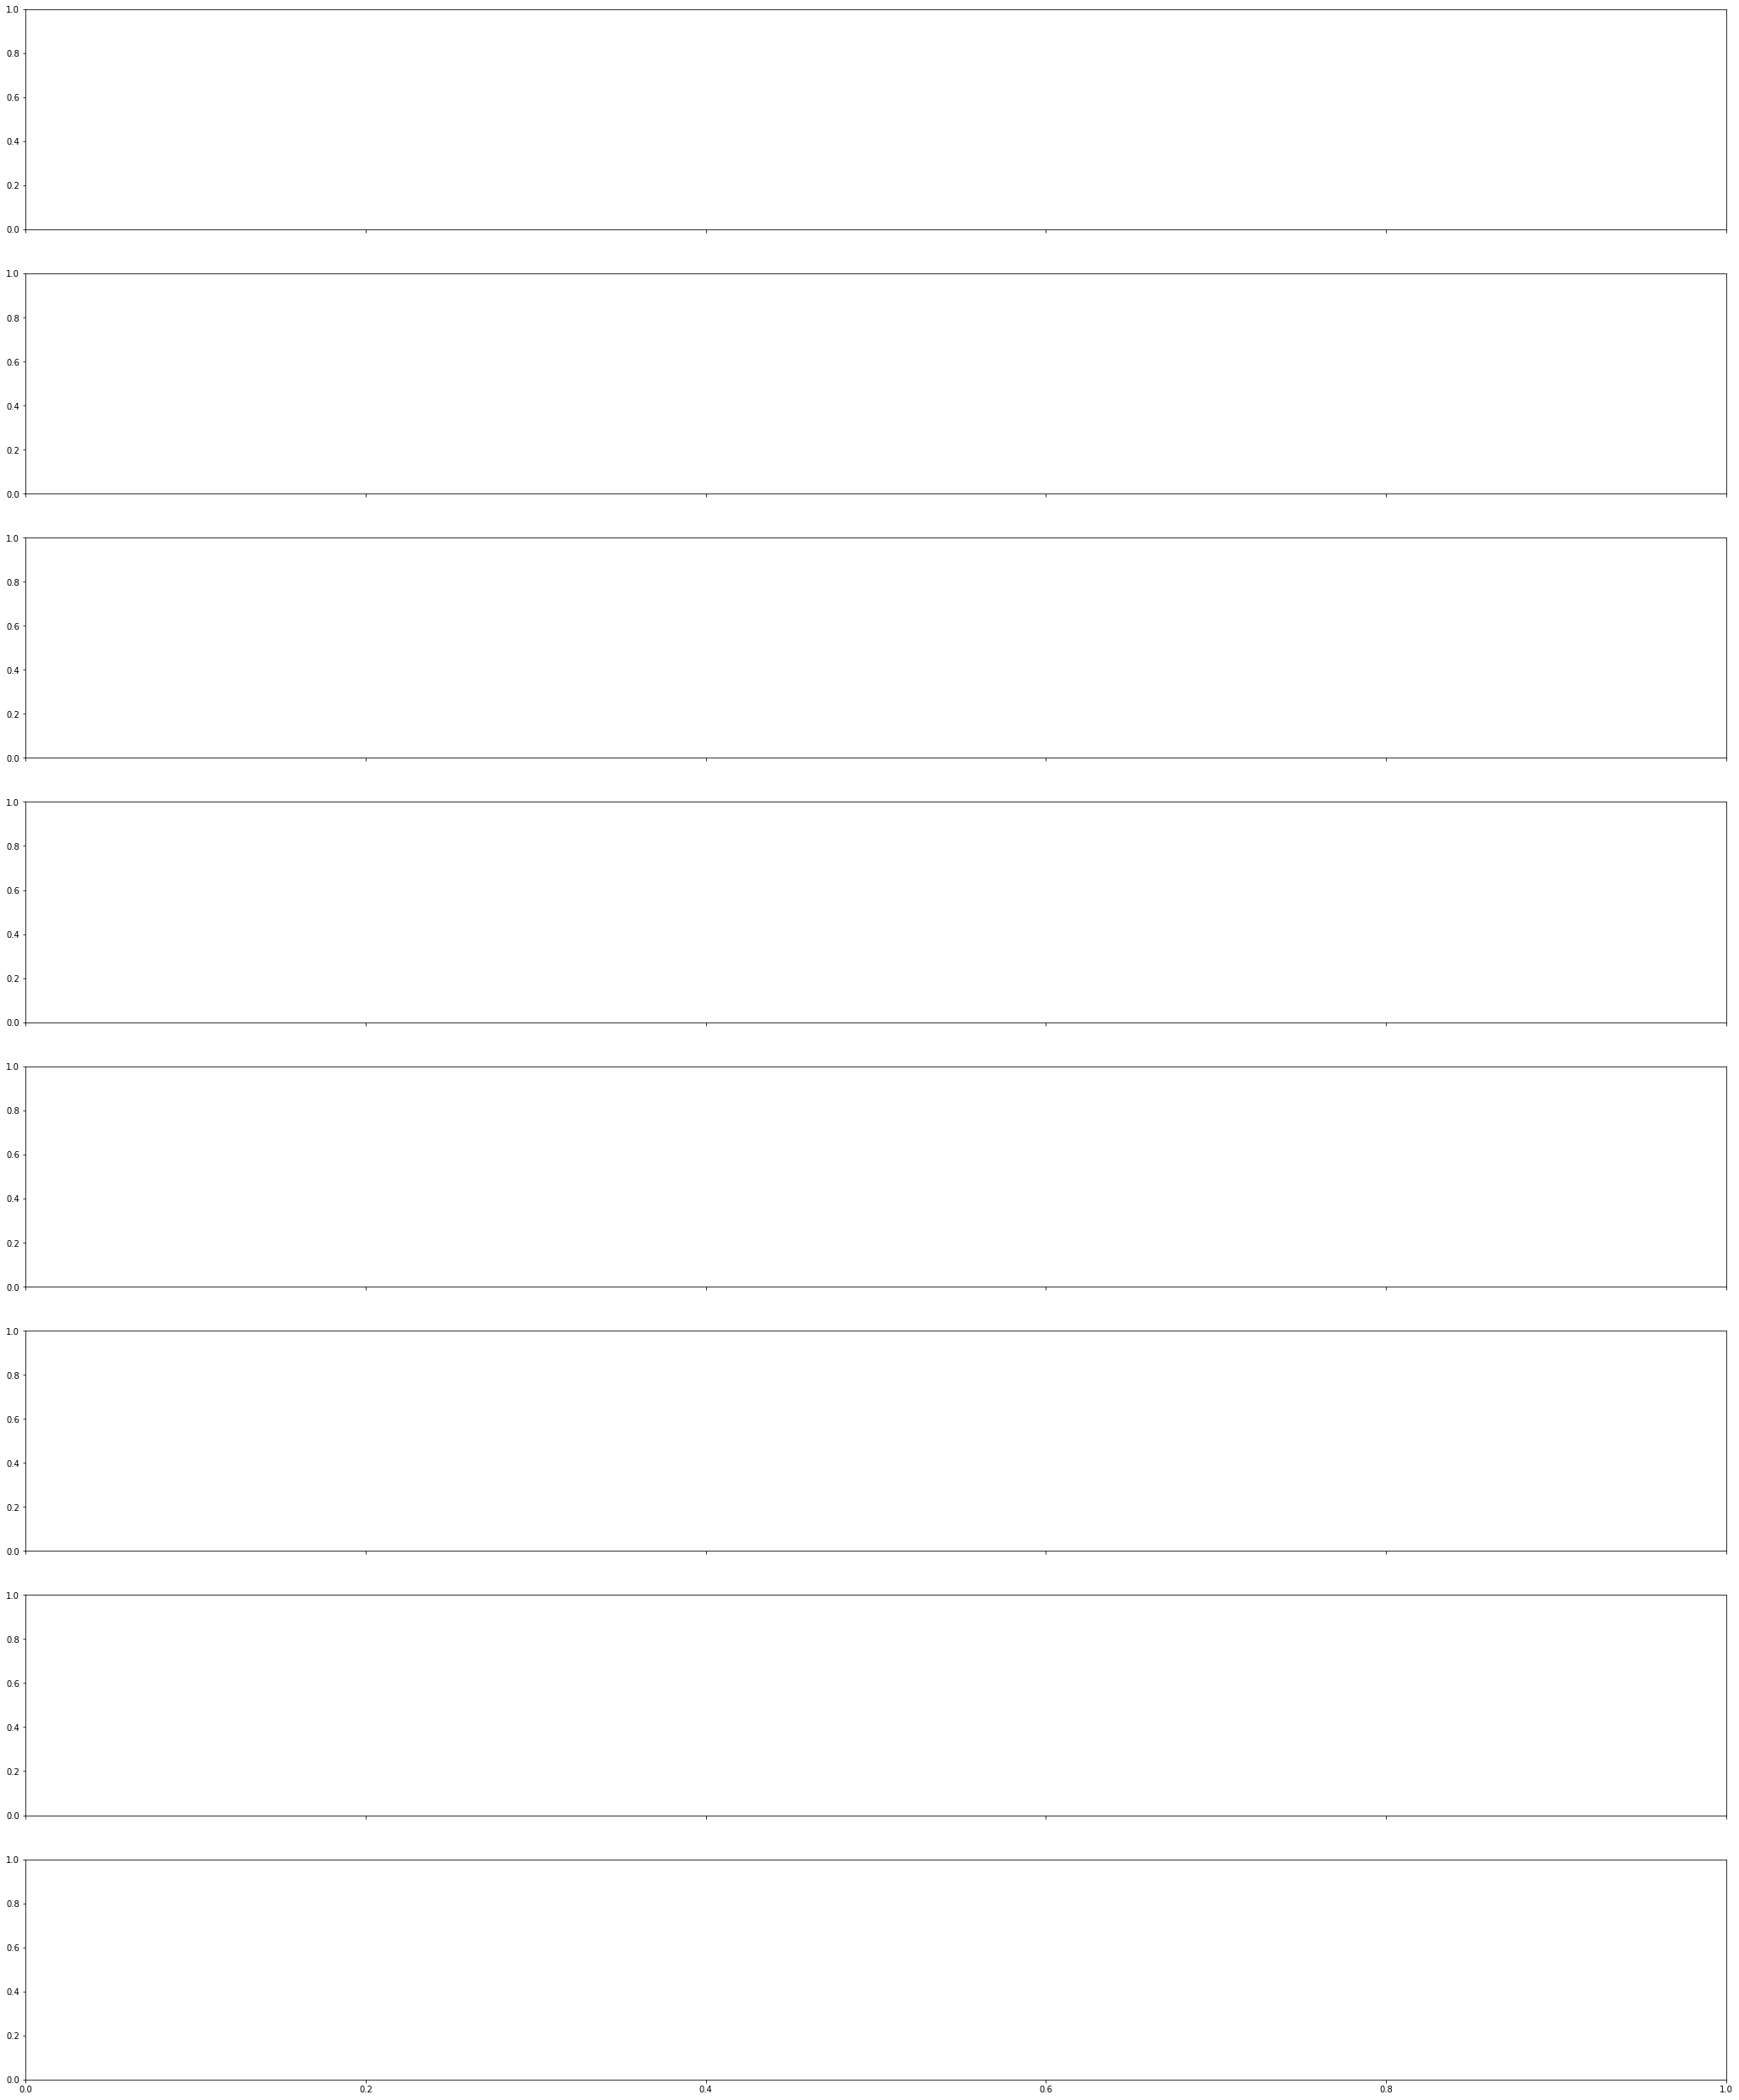

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=1,figsize=(36, 45),sharex=True)


fuel.plot(ax=axes[0],kind='bar', stacked=True,color=fuel_colors,rot=0)
plt.yticks(weight = 'bold', fontsize=12)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
axes[0].set_ylim(0, 3200)
axes[0].set_ylabel('Total fuel use \n (kg)',fontsize=12,fontweight='bold',labelpad=12)
axes[0].annotate('(a)', xy=(23, 3200*7.5/8), fontsize=12,weight = 'bold')
axes[0].set_yticklabels(axes[0].get_yticks(), size=12,weight = 'bold')  
axes[0].legend(loc='upper left')
axes[0].set_title('M8 vessel: L$_s$ = 110 m, B$_s$ = 11.40 m, h$_0$ = 2.5 m')

CO2.plot(ax=axes[1],kind='bar', stacked=True,color=CO2_colors,rot=0)
axes[1].set_ylim(0, 10000)
axes[1].set_ylabel('Total CO2 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=3)
axes[1].set_yticklabels(axes[1].get_yticks(), size=12,weight = 'bold')  
axes[1].annotate('(b)', xy=(23, 10000*7.5/8), fontsize=12,weight = 'bold')
axes[1].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

PM10.plot(ax=axes[2],kind='bar', stacked=True,color=PM10_colors,rot=0)
axes[2].set_ylim(0, 6)
axes[2].set_ylabel('Total PM10 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=25)
axes[2].annotate('(c)', xy=(23, 6*7.5/8), fontsize=12,weight = 'bold')
axes[2].set_yticklabels(axes[2].get_yticks(), size=12,weight = 'bold')  
axes[2].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

NOx.plot(ax=axes[3],kind='bar', stacked=True,color=NOx_colors,rot=0)
axes[3].set_ylim(0, 150)
axes[3].set_ylabel('Total NOx emission \n (kg)',fontsize=12,fontweight='bold',labelpad=10)  
axes[3].set_yticklabels(axes[3].get_yticks(), size=12,weight = 'bold')  
axes[3].annotate('(d)', xy=(23, 150*7.5/8), fontsize=12,weight = 'bold')
axes[3].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

Payload.plot(ax=axes[4],kind='bar', stacked=True,color=Payload_colors,rot=0)
axes[4].set_ylim(0, 1500)
axes[4].set_ylabel('payload \n (ton)',fontsize=12,fontweight='bold',labelpad=10)  
axes[4].set_yticklabels(axes[4].get_yticks(), size=12,weight = 'bold')  
axes[4].annotate('(e)', xy=(23, 1500*7.5/8), fontsize=12,weight = 'bold')
axes[4].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

duration.plot(ax=axes[5],kind='bar', stacked=True,color=duration_colors,rot=0)
axes[5].set_ylim(0, 25)
axes[5].set_ylabel('duration \n (hours)',fontsize=12,fontweight='bold',labelpad=20)  
axes[5].set_yticklabels(axes[5].get_yticks(), size=12,weight = 'bold')  
axes[5].annotate('(f)', xy=(23, 25*7.5/8), fontsize=12,weight = 'bold')
axes[5].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

sinkage_max.plot(ax=axes[6],kind='bar', stacked=True,color=sinkage_max_colors,rot=0)
axes[6].set_ylim(0, 10)
axes[6].set_ylabel('maximum sinkage \n (cm)',fontsize=12,fontweight='bold',labelpad=15)  
axes[6].set_yticklabels(axes[6].get_yticks(), size=12,weight = 'bold')  
axes[6].annotate('(g)', xy=(23, 10*7.5/8), fontsize=12,weight = 'bold')
axes[6].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

remaining_space.plot(ax=axes[7],kind='bar', stacked=True,color=remaining_space_colors,rot=0)
axes[7].set_ylim(0, 100)
axes[7].set_ylabel('remaining_space \n (cm)',fontsize=12,fontweight='bold',labelpad=5)  
axes[7].set_yticklabels(axes[6].get_yticks(), size=12,weight = 'bold')  
axes[7].annotate('(h)', xy=(23, 100*7.5/8), fontsize=12,weight = 'bold')
axes[7].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))


plt.xticks( weight = 'bold', fontsize=12)
plt.savefig('Strategies with v_max for passing bottleneck.png',bbox_inches = 'tight', dpi=600, format='png')  
plt.savefig('Strategies with v_max for passing bottleneck.pdf',bbox_inches = 'tight', dpi=600, format='pdf')  
plt.show()

### Define and Run "T_v_strategy_energy_simulation_whole3" for passing whole 3 sections (h_0: 6, 2.5, 6) with selected strategies (T_strategy = 2.1 m, v_strategy = [3, 3.5] m/s)

In [24]:
def T_v_strategy_energy_simulation_whole3(v_strategy, T_strategy):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel._T = T_strategy
    vessel.v = v_strategy
    

    #vessel.P_tot_given = P_tot_given
    #vessel.h_0 = vessel.h_0 - ((vessel.C_B * ((vessel.B * vessel._T) / (150 * vessel.h_0)) ** 0.81) * (vessel.v ** 2.08) / 20)
    # Start the simulation
    env.process(vessel.move())
    env.run()
#    print(vessel.h_0)
    return vessel

ERROR! Session/line number was not unique in database. History logging moved to new session 1468


In [25]:
T_strategy_n10 = [2.1] 
v_strategy_n10 = [3, 3.5]



In [26]:
vessel1= T_v_strategy_energy_simulation_whole3(3, 2.1)

In [ ]:
df_collect = {}
sinkage_max = {}


for i, row in tqdm.tqdm(T_v_Strategies_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)   
    
    v_strategy = row['v_strategy']
    T_strategy = row['T_strategy']
    
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel=  run_simulation(v_strategy, T_strategy)
    # z = (vessel.C_B * ((vessel.B * vessel.T) / (150 * vessel.h_min)) ** 0.81) * (v_computed ** 2.08) / 20
  

    # sinkage_max = z

    #create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    #P_tot = vessel.calculate_total_power_required(v_computed)
    
    # create dataframe from energy calculation computation
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    df.update(row)
    
    # add/modify some comlums to suit our plotting needs
    # df['P_tot'] = P_tot
    df['fuel_kg_bottleneck'] = df['total_fuel_consumption']/1000   # g --> kg
    df['CO2_kg_bottleneck']   = df['total_emission_CO2']/1000
    df['PM10_kg_bottleneck']  = df['total_emission_PM10']/1000
    df['NOx_kg_bottleneck']   = df['total_emission_NOX']/1000
    df['duration_hrs_bottleneck'] = df['delta_t'] /3600  # s--> hour
    # df['sinkage_max_m_bottleneck'] = sinkage_max
    # df['Payload_strategy_ton_bottleneck'] = Payload_strategy
    
    
    label = 'T_strategy = ' + str(T_strategy) + ' v_strategy = ' + str(round(v_strategy,2))
    
    df_collect[label + ' P_tot']   = list(df.P_tot[[0]])
    df_collect[label + ' P_installed'] = list(df.P_installed[[0]])
    df_collect[label + ' duration_hrs_bottleneck']   = list(df.duration_hrs_bottleneck[[0]])
    df_collect[label + ' fuel_kg_bottleneck']   = list(df.fuel_kg_bottleneck[[0]])
    df_collect[label + ' CO2_kg_bottleneck'] = list(df.CO2_kg_bottleneck[[0]])
    df_collect[label + ' PM10_kg_bottleneck']   = list(df.PM10_kg_bottleneck[[0]])
    df_collect[label + ' NOx_kg_bottleneck']   = list(df.NOx_kg_bottleneck[[0]])
    # df_collect[label + ' sinkage_max_m_bottleneck']   = list(df.sinkage_max_m_bottleneck[[0]])

    # df_output['T_strategy']   = list(Strategies_df.T_strategy[0:17])
    # df_output['v_computed']   = list(Strategies_df.v_computed[0:17])
    # df_output['P_tot']   = list(df.P_tot[[0]])
    # df_output[' P_installed'] = list(df.P_installed[[0]])
    # df_output[' duration_hrs_bottleneck']   = list(df.duration_hrs_bottleneck[[0]])
    # df_output[' fuel_kg_bottleneck']   = list(df.fuel_kg_bottleneck[[0]])
    # df_output[' CO2_g_bottleneck'] = list(df.CO2_g_bottleneck[[0]])
    # df_output[' PM10_g_bottleneck']   = list(df.PM10_g_bottleneck[[0]])
    # df_output[' NOx_g_bottleneck']   = list(df.NOx_g_bottleneck[[0]])

    


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'T_v_Strategies_df' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'T_v_Strategies_df' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of

In [27]:
df_collect

{}

### Visulization of Stratigies for passing bottleneck section

#### Organizing data for visulization 

In [28]:
df_plot = pd.DataFrame( df_collect )
df_plot

ERROR! Session/line number was not unique in database. History logging moved to new session 1469


""


In [ ]:
fuel=df_plot[['T_strategy = 2.15 v_computed = 1.4 fuel_kg_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 fuel_kg_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 fuel_kg_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 fuel_kg_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 fuel_kg_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 fuel_kg_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 fuel_kg_bottleneck']].T

fuel.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

fuel.columns =['section 2 (bottleneck)']
fuel.head(7)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 fuel_kg_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 fuel_kg_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 fuel_kg_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 fuel_kg_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 fuel_kg_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 fuel_kg_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 fuel_kg_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 fuel_kg_bottleneck',\n       'T_strategy = 2.1 

In [ ]:
fuel_colors=['#bf9005']
fuel.plot(kind='bar',stacked=True,color=fuel_colors,rot=0, figsize=(10, 3))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'fuel' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'fuel' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, anot

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



AssertionError
ERROR! Session/line number was not unique in database. History logging moved to new session 1470
Traceback (most recent call last):
NameError: name 'fuel' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no at

In [ ]:
CO2=df_plot[[ 'T_strategy = 2.15 v_computed = 1.4 CO2_kg_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 CO2_kg_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 CO2_kg_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 CO2_kg_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 CO2_kg_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 CO2_kg_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 CO2_kg_bottleneck']].T

CO2.index=[ 'strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

CO2.columns =['section 2 (bottleneck)']
CO2.head(7)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 CO2_kg_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 CO2_kg_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 CO2_kg_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 CO2_kg_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 CO2_kg_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 CO2_kg_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 CO2_kg_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
ERROR! Session/line number was not unique in database. History logging moved to new session 1471
Traceback (most recent call last):
KeyError: "None of [

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 CO2_kg_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 CO2_kg_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 CO2_kg_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 CO2_kg_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 CO2_kg_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 CO2_kg_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 CO2_kg_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurre

In [ ]:
CO2_colors=['orange']
CO2.plot(kind='bar', stacked=True,color=CO2_colors,rot=0, figsize=(10, 3))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'CO2' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'CO2' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
ERROR! Session/line number was not unique in database. History logging moved to new session 1472
Traceback (most recent call last):
NameError: name 'CO2' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameEr

In [ ]:
PM10=df_plot[['T_strategy = 2.15 v_computed = 1.4 PM10_kg_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 PM10_kg_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 PM10_kg_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 PM10_kg_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 PM10_kg_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 PM10_kg_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 PM10_kg_bottleneck']].T

PM10.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

PM10.columns =['section 2 (bottleneck)']
PM10.head(7)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 PM10_kg_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 PM10_kg_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 PM10_kg_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 PM10_kg_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 PM10_kg_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 PM10_kg_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 PM10_kg_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
ERROR! Session/line number was not unique in database. History logging moved to new session 1473
Traceback (most recent call last):
KeyError: "No

In [ ]:
PM10_colors=['mediumseagreen']
PM10.plot(kind='bar', stacked=True,color=PM10_colors,rot=0, figsize=(10, 3))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'PM10' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
ERROR! Session/line number was not unique in database. History logging moved to new session 1474
Traceback (most recent call last):
NameError: name 'PM10' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'Type

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'PM10' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (mo

In [ ]:
NOx=df_plot[['T_strategy = 2.15 v_computed = 1.4 NOx_kg_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 NOx_kg_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 NOx_kg_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 NOx_kg_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 NOx_kg_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 NOx_kg_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 NOx_kg_bottleneck']].T

NOx.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

NOx.columns =['section 2 (bottleneck)']
NOx.head(7)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 NOx_kg_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 NOx_kg_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 NOx_kg_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 NOx_kg_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 NOx_kg_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 NOx_kg_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 NOx_kg_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 NOx_kg_bottleneck',\n       'T_strategy = 2.1 v_comput

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 NOx_kg_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 NOx_kg_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 NOx_kg_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 NOx_kg_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 NOx_kg_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 NOx_kg_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 NOx_kg_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeErr

In [ ]:
NOx_colors=['deeppink']
NOx.plot(kind='bar', stacked=True,color=NOx_colors,rot=0, figsize=(10, 3))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'NOx' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'NOx' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, anothe

In [ ]:
Payload = Strategies_df['Payload_strategy'][0:7]
Payload = pd.DataFrame(Payload)

Payload.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

Payload.columns =['section 2 (bottleneck)']
Payload.head(7)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: 'Payload_strategy'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
KeyError: 'Payload_strategy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
KeyError: 'Payload_strategy'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
KeyError: 'Payload_strategy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of ty

In [ ]:
Payload_colors=['yellowgreen']
Payload.plot(kind='bar', stacked=True,color=Payload_colors,rot=0, figsize=(10, 3))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'Payload' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'Payload' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception

In [ ]:
duration=df_plot[['T_strategy = 2.15 v_computed = 1.4 duration_hrs_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 duration_hrs_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 duration_hrs_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 duration_hrs_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 duration_hrs_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 duration_hrs_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 duration_hrs_bottleneck']].T

duration.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

duration.columns =['section 2 (bottleneck)']
duration.head(7)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 duration_hrs_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 duration_hrs_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 duration_hrs_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 duration_hrs_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 duration_hrs_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 duration_hrs_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 duration_hrs_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
ERROR! Session/line number was not unique in database. History logging moved to new session 1479
Traceback (mo

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 duration_hrs_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 duration_hrs_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 duration_hrs_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 duration_hrs_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 duration_hrs_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 duration_hrs_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 duration_hrs_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Trace

In [ ]:
duration_colors=['mediumpurple']
duration.plot(kind='bar', stacked=True,color=duration_colors,rot=0, figsize=(10, 3))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'duration' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'duration' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above excepti

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'duration' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback

In [ ]:
sinkage_max=df_plot[['T_strategy = 2.15 v_computed = 1.4 sinkage_max_m_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 sinkage_max_m_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 sinkage_max_m_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 sinkage_max_m_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 sinkage_max_m_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 sinkage_max_m_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 sinkage_max_m_bottleneck']].T

sinkage_max.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

sinkage_max.columns =['section 2 (bottleneck)']
sinkage_max.head(7)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 sinkage_max_m_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 sinkage_max_m_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 sinkage_max_m_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 sinkage_max_m_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 sinkage_max_m_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 sinkage_max_m_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 sinkage_max_m_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 1481
Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 sinkage_max_m_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 sinkage_max_m_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 sinkage_max_m_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 sinkage_max_m_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 sinkage_max_m_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 sinkage_max_m_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 sinkage_max_m_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of 

In [ ]:
sinkage_max_colors=['tomato']
sinkage_max.plot(kind='bar', stacked=True,color=sinkage_max_colors,rot=0, figsize=(10, 3))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
AttributeError: 'dict' object has no attribute 'plot'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
AttributeError: 'dict' object has no attribute 'plot'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

Du

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 1482
Traceback (most recent call last):
AttributeError: 'dict' object has no attribute 'plot'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has

In [ ]:
dynamic_ukc=df_plot[['T_strategy = 2.15 v_computed = 1.4 dynamic_ukc_m_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 dynamic_ukc_m_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 dynamic_ukc_m_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 dynamic_ukc_m_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 dynamic_ukc_m_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 dynamic_ukc_m_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 dynamic_ukc_m_bottleneck']].T

dynamic_ukc.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

dynamic_ukc.columns =['section 2 (bottleneck)']
dynamic_ukc.head(7)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 dynamic_ukc_m_bottleneck',\n       'T_strategy = 2.1 v_computed = 2.0 dynamic_ukc_m_bottleneck',\n       'T_strategy = 2.05 v_computed = 2.46 dynamic_ukc_m_bottleneck',\n       'T_strategy = 2.0 v_computed = 2.86 dynamic_ukc_m_bottleneck',\n       'T_strategy = 1.95 v_computed = 3.22 dynamic_ukc_m_bottleneck',\n       'T_strategy = 1.9 v_computed = 3.54 dynamic_ukc_m_bottleneck',\n       'T_strategy = 1.85 v_computed = 3.85 dynamic_ukc_m_bottleneck'],\n      dtype='object')] are in the [columns]"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
KeyError: "None of [Index(['T_strategy = 2.15 v_computed = 1.4 dynam

In [ ]:
dynamic_ukc_colors=['deepskyblue']
dynamic_ukc.plot(kind='bar', stacked=True,color=dynamic_ukc_colors,rot=0, figsize=(10, 3))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 1483
Traceback (most recent call last):
ERROR! Session/line number was not unique in NameError: name 'dynamic_ukc' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
database. History logging moved to new session 1484


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'dynamic_ukc' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
NameError: name 'dynamic_ukc' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above e

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
NameError: name 'fuel' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
ERROR! Session/line number was not unique in database. History logging moved to new session 1485
Traceback (most recent call last):
NameError: name 'fuel' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'Type

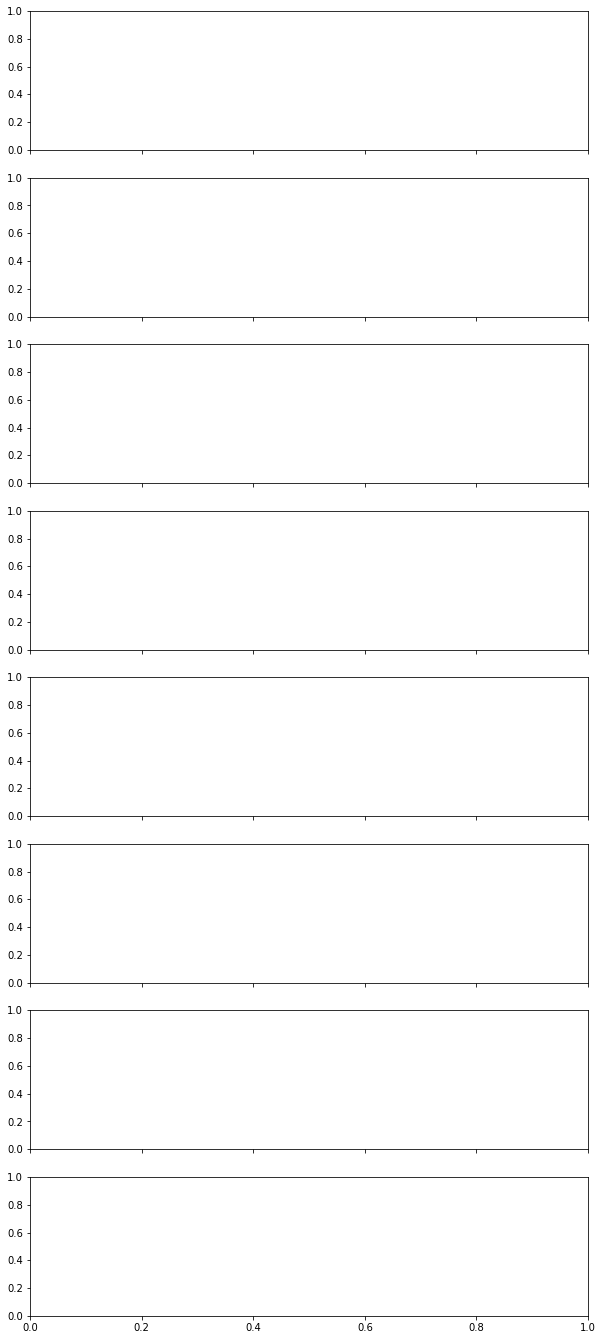

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=1,figsize=(10, 24),sharex=True)


fuel.plot(ax=axes[0],kind='bar', stacked=True,color=fuel_colors,rot=0)
plt.yticks(weight = 'bold', fontsize=12)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
axes[0].set_ylim(0, 3000)
axes[0].set_ylabel('Total fuel use \n (kg)',fontsize=12,fontweight='bold',labelpad=12)
axes[0].annotate('(a)', xy=(6, 3000*7/8), fontsize=12,weight = 'bold')
axes[0].set_yticklabels(axes[0].get_yticks(), size=12,weight = 'bold')  
axes[0].legend(loc='upper left')
axes[0].set_title('M8 vessel: L$_s$ = 110 m, B$_s$ = 11.40 m, h$_0$ = 2.5 m')

CO2.plot(ax=axes[1],kind='bar', stacked=True,color=CO2_colors,rot=0)
axes[1].set_ylim(0, 9000)
axes[1].set_ylabel('Total CO2 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=3)
axes[1].set_yticklabels(axes[1].get_yticks(), size=12,weight = 'bold')  
axes[1].annotate('(b)', xy=(6, 9000*7/8), fontsize=12,weight = 'bold')
axes[1].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

PM10.plot(ax=axes[2],kind='bar', stacked=True,color=PM10_colors,rot=0)
axes[2].set_ylim(0, 5)
axes[2].set_ylabel('Total PM10 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=27)
axes[2].annotate('(c)', xy=(6, 5*7/8), fontsize=12,weight = 'bold')
axes[2].set_yticklabels(axes[2].get_yticks(), size=12,weight = 'bold')  
axes[2].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

NOx.plot(ax=axes[3],kind='bar', stacked=True,color=NOx_colors,rot=0)
axes[3].set_ylim(0, 120)
axes[3].set_ylabel('Total NOx emission \n (kg)',fontsize=12,fontweight='bold',labelpad=20)  
axes[3].set_yticklabels(axes[3].get_yticks(), size=12,weight = 'bold')  
axes[3].annotate('(d)', xy=(6, 120*7/8), fontsize=12,weight = 'bold')
axes[3].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

Payload.plot(ax=axes[4],kind='bar', stacked=True,color=Payload_colors,rot=0)
axes[4].set_ylim(0, 2000)
axes[4].set_ylabel('payload \n (ton)',fontsize=12,fontweight='bold',labelpad=20)  
axes[4].set_yticklabels(axes[4].get_yticks(), size=12,weight = 'bold')  
axes[4].annotate('(e)', xy=(6, 2000*7/8), fontsize=12,weight = 'bold')
axes[4].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

duration.plot(ax=axes[5],kind='bar', stacked=True,color=duration_colors,rot=0)
axes[5].set_ylim(0, 25)
axes[5].set_ylabel('duration \n (hours)',fontsize=12,fontweight='bold',labelpad=20)  
axes[5].set_yticklabels(axes[5].get_yticks(), size=12,weight = 'bold')  
axes[5].annotate('(f)', xy=(6, 25*7/8), fontsize=12,weight = 'bold')
axes[5].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

sinkage_max.plot(ax=axes[6],kind='bar', stacked=True,color=sinkage_max_colors,rot=0)
axes[6].set_ylim(0, 0.6)
axes[6].set_ylabel('maximum sinkage \n (m)',fontsize=12,fontweight='bold',labelpad=0)  
axes[6].set_yticklabels(axes[6].get_yticks(), size=12,weight = 'bold')  
axes[6].annotate('(g)', xy=(6, 0.6*7/8), fontsize=12,weight = 'bold')
axes[6].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

dynamic_ukc.plot(ax=axes[7],kind='bar', stacked=True,color=dynamic_ukc_colors,rot=0)
axes[7].set_ylim(0, 0.6)
axes[7].set_ylabel('dynamic ukc \n (m)',fontsize=12,fontweight='bold',labelpad=20)  
axes[7].set_yticklabels(axes[6].get_yticks(), size=12,weight = 'bold')  
axes[7].annotate('(h)', xy=(6, 0.6*7/8), fontsize=12,weight = 'bold')
axes[7].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))


plt.xticks( weight = 'bold', fontsize=12)

plt.savefig('Strategies for passing bottleneck.pdf',bbox_inches = 'tight', dpi=600, format='pdf')  
plt.show()

### Define "T_v_strategy_energy_simulation" for passing 3 whole sections (h_0: 6 m, 2.5 m, 6 m)

In [29]:
def T_v_strategy_energy_simulation(v_strategy, T_strategy):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel._T = T_strategy
    vessel.v = v_strategy
    
 
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

ERROR! Session/line number was not unique in database. History logging moved to new session 1486


### Run "T_v_strategy_energy_simulation" for passing 3 whole sections (h_0: 6 m, 2.5 m, 6 m)

### Visulization of Stratigies for passing  3 whole sections (h_0: 6 m, 2.5 m, 6 m)

In [30]:
use dataframe as input run simulation and plot multi-figure sets with strategies, refer to figure 3 5 7 8 9 notebook

SyntaxError: invalid syntax (<ipython-input-30-01640fc8f89e>, line 1)

In [ ]:
do the same to fig 10, 11,13,14,15

In [ ]:
will also influence 3 5 7 8 9, due to v, h_0 variation